In [1]:
%matplotlib inline
import _init_paths

from model.config import cfg
from model.test import im_detect
from model.nms_wrapper import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse
from PIL import Image
from PIL import ImageDraw
from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1

import torch

CLASSES = ('__background__',
           'chinese', 'english', 'number')


In [2]:
def test(image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    net = resnetv1(num_layers=101)
    net.create_architecture(4, tag='default', anchor_scales=[8, 16, 32])

    net.load_state_dict(torch.load(os.path.join('../output', 'res101', 'NameCardtrainvalNameCardReal', 'default',
                              'res101_faster_rcnn_iter_200000.pth'), map_location=lambda storage, loc: storage))
    net.eval()
    if not torch.cuda.is_available():
        net._device = 'cpu'
    net.to(net._device)
    # Load the demo image
    im_file = os.path.join(image_name)
    im = cv2.imread(im_file)
    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    # Visualize detections for each class
    CONF_THRESH = 0.9
    NMS_THRESH = 0.3
    box_out = []
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(torch.from_numpy(dets), NMS_THRESH)
        dets = dets[keep.numpy(), :]
        inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
        dets = dets[inds].astype(int)[:,:4]
        box_out.append(dets)
    return box_out

../data/NameCard/NameCardReal/JPEGImages/0021.jpg 525 388 681 416 1 0 0
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 527 353 695 379 1 0 0
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 140 197 705 223 0 1 0
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 140 132 689 192 0 0 1
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 447 391 501 421 0 0 1
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 217 331 358 379 0 0 1
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 248 393 329 422 0 0 1
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 524 317 685 346 0 0 1
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 447 358 498 383 0 0 1
../data/NameCard/NameCardReal/JPEGImages/0021.jpg 445 321 497 348 0 0 1


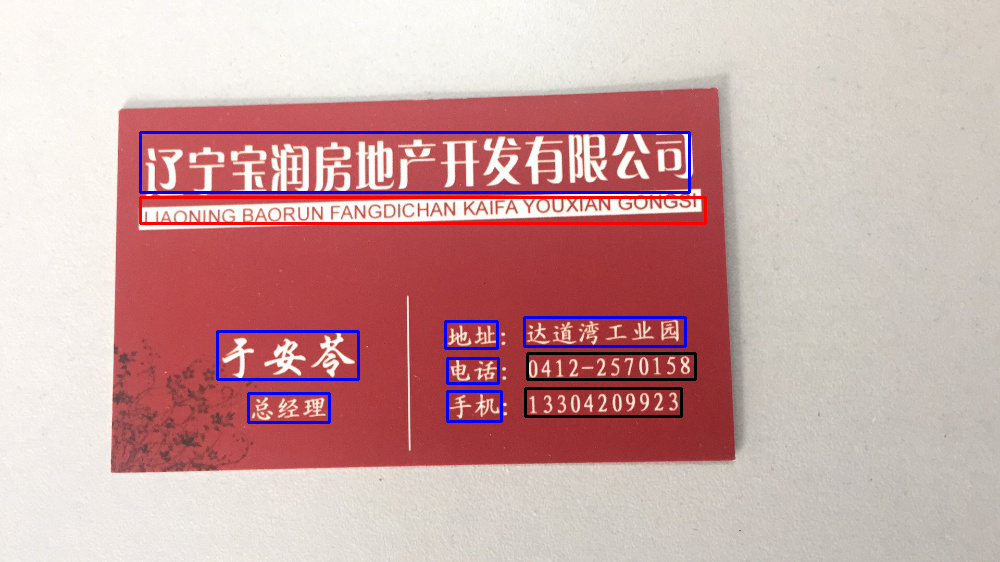

In [5]:
name = '../data/NameCard/NameCardReal/JPEGImages/0021.jpg'
boxes = test(name)
im = Image.open(name)
draw = ImageDraw.Draw(im)
# number output
for box in boxes[2]:
    print('{} {} {} {} {} 1 0 0'.format(name,box[0],box[1],box[2],box[3]))
    draw.line((box[0],box[1],box[0],box[3]),width=3,fill=(0,0,0))
    draw.line((box[2],box[1],box[2],box[3]),width=3,fill=(0,0,0))
    draw.line((box[0],box[1],box[2],box[1]),width=3,fill=(0,0,0))
    draw.line((box[0],box[3],box[2],box[3]),width=3,fill=(0,0,0))
# english output
for box in boxes[1]:
    print('{} {} {} {} {} 0 1 0'.format(name,box[0],box[1],box[2],box[3]))
    draw.line((box[0],box[1],box[0],box[3]),width=3,fill=(255,0,0))
    draw.line((box[2],box[1],box[2],box[3]),width=3,fill=(255,0,0))
    draw.line((box[0],box[1],box[2],box[1]),width=3,fill=(255,0,0))
    draw.line((box[0],box[3],box[2],box[3]),width=3,fill=(255,0,0))
# chinese output
for box in boxes[0]:
    print('{} {} {} {} {} 0 0 1'.format(name,box[0],box[1],box[2],box[3]))
    draw.line((box[0],box[1],box[0],box[3]),width=3,fill=(0,0,255))
    draw.line((box[2],box[1],box[2],box[3]),width=3,fill=(0,0,255))
    draw.line((box[0],box[1],box[2],box[1]),width=3,fill=(0,0,255))
    draw.line((box[0],box[3],box[2],box[3]),width=3,fill=(0,0,255))
im